In [2]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")


import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.rnn_optimizer import kl_divergence
from utils.utils import Experiment, get_model, create_def_argparser, get_experiment, create_logger
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, create_x_val_array, plot_kl_div_parts
from utils.plots import get_exper_loss_data, plot_val_result, plot_exper_losses, plot_parm_loss_steps
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic

%load_ext autoreload
%autoreload 2

In [2]:
expers_to_load = [(True, "run_20170625_12_36_48_metaV1_60ep_100ops_lr5e06_adam"),
                  (True, "run_20170625_18_56_22_metaV1_60ep_100ops_retrain_lr5e06_adam"),
                  (False, "run_20170620_19_49_09_metaV1_60ep_40ops_lr1e05_adam"),
                  # META V2 model (trained with T samples)
                  (False, "run_20170521_16_29_59_metaV2_30ep_10ops_lr5e05_adam"),
                  (False, "run_20170521_16_44_03_metaV2_30ep_5ops_lr5e05_adam"),
                  (False, "run_20170521_16_40_41_metaV2_30ep_2ops_lr5e05_adam"),
                  # ACT V1 model (2 LSTMS)
                  (False, "run_20170521_15_04_08_actV2.1_30ep_10ops_lr5e05_adam"),
                  (False, "run_20170521_14_52_18_actV2.1_30ep_5ops_lr5e05_adam"),
                  (False, "run_20170521_14_58_37_actV2.1_30ep_2ops_lr5e05_adam"),
                  # ACT V2 model (1 LSTM)
                  (False, "run_20170602_14_11_17_actV2_60ep_10ops_lr1e05_adam"),
                  (False, "run_20170621_10_10_15_actV2_80ep_10ops_lr1e05_adam"),
                  (False, "run_20170602_19_20_08_actV2_60ep_20ops_lr1e05_adam"),
                  (False, "run_20170620_22_21_20_actV2_60ep_40ops_lr1e05_adam")]



In [3]:
without_models = False

experiments = []
models = []
new_experiments = []
explogger = None
m = 0
for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        exp = get_experiment(exp_path[1])
        print("{} Loading model {}".format(m, exp.args.model))
        
        experiments.append(exp)
        if explogger is None:
            explogger = create_logger(exp, file_handler=False)
        m += 1
        if not without_models:
            models.append(get_model(exp, exp.args.x_dim, retrain=True, logger=explogger))
        new_experiments.append(copy.deepcopy(exp))
        new_experiments[-1].reset_val_stats()


0 Loading model metaV1_lr5e-06_adam_100ops
Using cuda for MetaLearner


INFO - INFO - loaded existing model from file logs/run_20170625_12_36_48_metaV1_60ep_100ops_lr5e06_adam/metaV1_lr5e-06_adam_100ops.pkl
INFO - INFO - loaded existing model from file logs/run_20170625_18_56_22_metaV1_60ep_100ops_retrain_lr5e06_adam/metaV1_lr5e-06_adam_100ops.pkl


['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'linear_out.bias']
1 Loading model metaV1_lr5e-06_adam_100ops
Using cuda for MetaLearner
['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight', 'linear_out.bias']


201
INFO - Successfully saved fig figures/10d_quadratics_metaV1_08_58_56.png


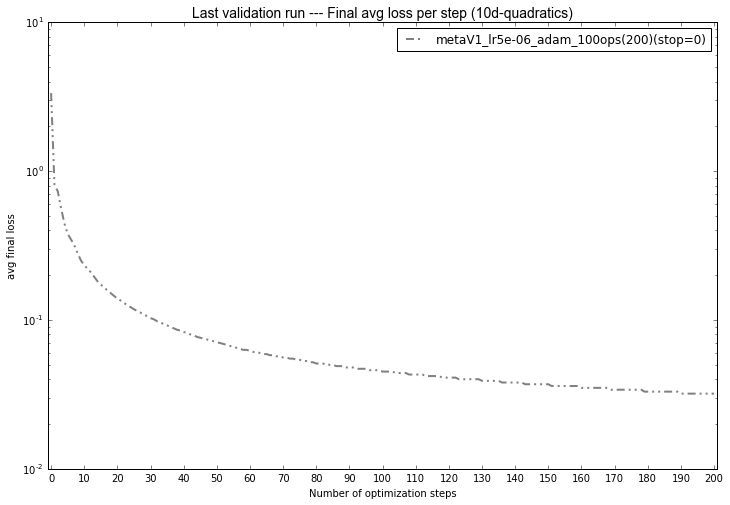

In [16]:
new_exp_only = [new_experiments[1]] #, new_experiments[1]]
best_val_runs, lowest_value = plot_val_result(new_exp_only, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10d_quadratics_metaV1", 
                                              loss_type="loss",
                                              max_step=201,
                                              sort_exper="10d-quadratics",
                                              log_scale=True)

INFO - Successfully saved fig logs/run_20170602_19_20_08_actV2_60ep_20ops_lr1e05_adam/qt_T_dist_train_actV2_60ep_20ops.png


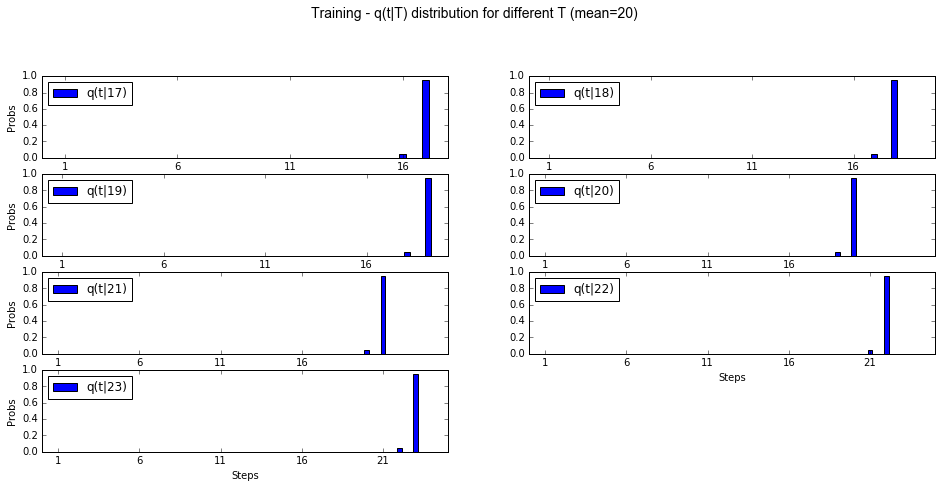

In [12]:
plot_qt_probs(experiments[1], data_set="train", show=True, plot_prior=False, save=True)

actV2_lr1e-05_adam_10ops


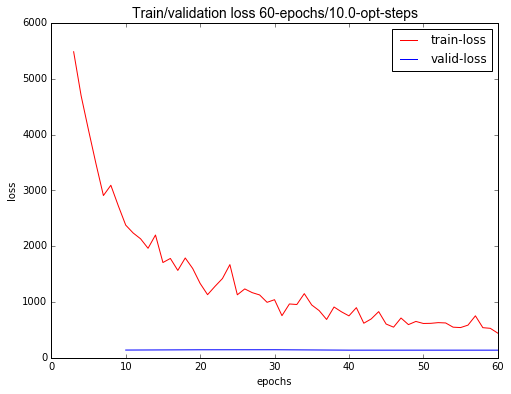

actV2_lr1e-05_adam_20ops


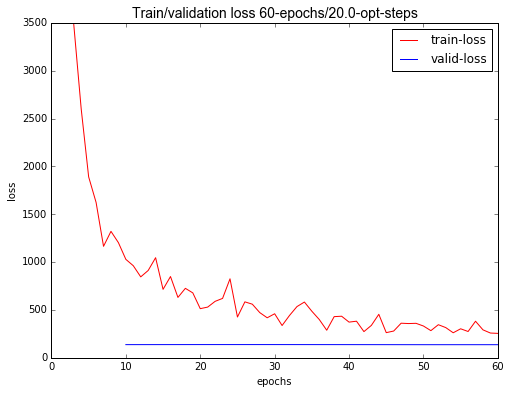

actV2_lr1e-05_adam_40ops


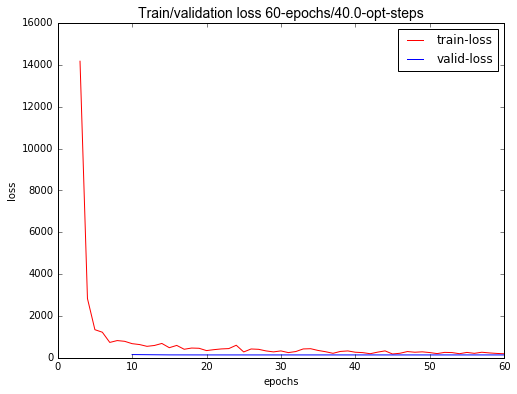

In [4]:
# exp_error_curves = [experiments[0],  experiments[3]]
for exp, mdl in zip(experiments, models):
    print(mdl.name)
    loss_plot(exp, loss_type="loss", save=False, validation=True, show=True)


INFO - Successfully saved fig figures/expv5_val_results_1000_loss_10ops_12_01_09.png


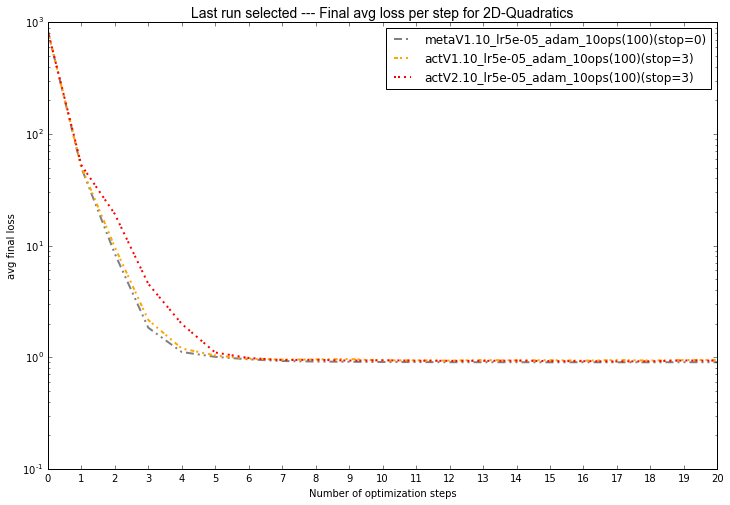

In [27]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [14]:
for exp in experiments:
    print(exp.config.max_val_opt_steps)

40
40
40
40
50
40


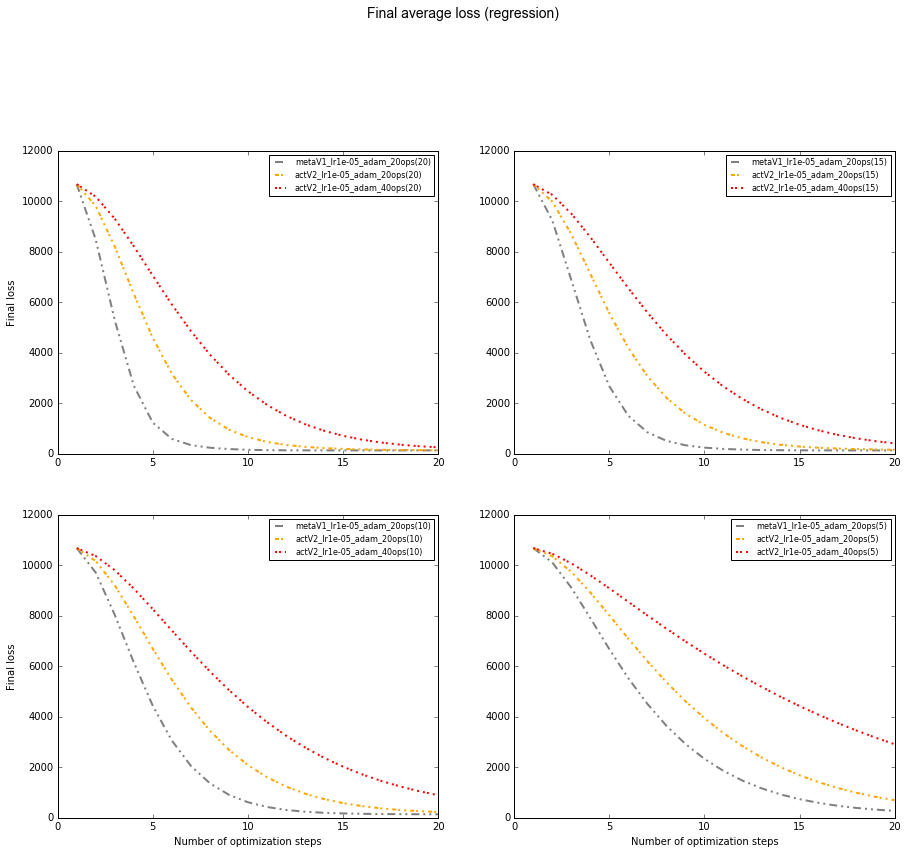

In [5]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [6]:
val_funcs = RegressionFunction(n_funcs=20000, n_samples=10, stddev=0.01, 
                             x_dim=10)
with open("data/val_funcs_10000_100_0.01_10.dll", 'wb') as f:
     dill.dump(val_funcs, f)
print("Success")

Success


In [5]:
"""
    Create some new validation functions
"""
num_of_val_funcs = 20000
val_funcs = L2LQuadratic(batch_size=num_of_val_funcs, num_dims=10, stddev=0.01, use_cuda=True)
print("Ready")

Ready


In [5]:
with open("data/val_funcs_15000.dll", 'wb') as f:
    dill.dump(val_funcs, f)
print("Success")

Success


In [5]:
print(config.max_val_opt_steps)

20


In [6]:
print(len(new_experiments))
exp_idx = 1
max_steps = 200
new_experiments[exp_idx].epoch = 200
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {}".format(model.name))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=val_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5)

INFO - ---------------------------------------------------------------------------------------
INFO - INFO - Epoch 200: Validating model metaV1_lr5e-06_adam_100ops with 20000 functions


2
Validating model metaV1_lr5e-06_adam_100ops


INFO - INFO - Epoch 200: Final validation average loss / param-loss: 0.03165/1.284e+06
INFO - INFO - Epoch 200: Final step param-losses: [ 1284015.5    1284015.25   1284015.25   1284015.     1284015.125  1284015.
  1284014.5    1284014.25   1284013.875  1284013.375  1284013.375
  1284012.875  1284012.75   1284012.125  1284012.     1284011.75
  1284011.625  1284011.125  1284010.875  1284010.75   1284010.375  1284010.
  1284009.875  1284009.5    1284009.375  1284009.     1284008.625
  1284008.125  1284007.875  1284007.75   1284007.625  1284007.25
  1284007.25   1284007.     1284006.625  1284006.5    1284006.125  1284006.
  1284005.5    1284005.375  1284005.125  1284004.875  1284004.5
  1284004.375  1284004.125  1284004.     1284003.75   1284003.75
  1284003.625  1284003.125  1284003.     1284002.625  1284002.625
  1284002.375  1284002.25   1284001.875  1284001.5    1284001.5    1284001.25
  1284001.125  1284001.     1284000.625  1284000.625  1284000.5
  1284000.375  1284000.25   1283999.

In [ ]:

INFO - INFO - Epoch 200: Final validation average loss / param-loss: 0.1179/2.417
INFO - INFO - Epoch 200: Final step losses: [ 3.337  2.219  0.788  0.965  0.68   0.646  0.606  0.49   0.465  0.416
  0.378  0.353  0.322  0.302  0.287  0.274  0.263  0.25   0.239  0.228
  0.218  0.209  0.201  0.193  0.186  0.18   0.173  0.167  0.162  0.157
  0.152  0.148  0.143  0.14   0.136  0.132  0.129  0.126  0.123  0.12
  0.118]

In [156]:
# exper = get_experiment('run_20170515_13_53_49_actV2_20ep_10ops_lr5e05_adam')
exper = get_experiment("run_20170525_19_39_19_actV2_30ep_20ops_lr5e05_adam")

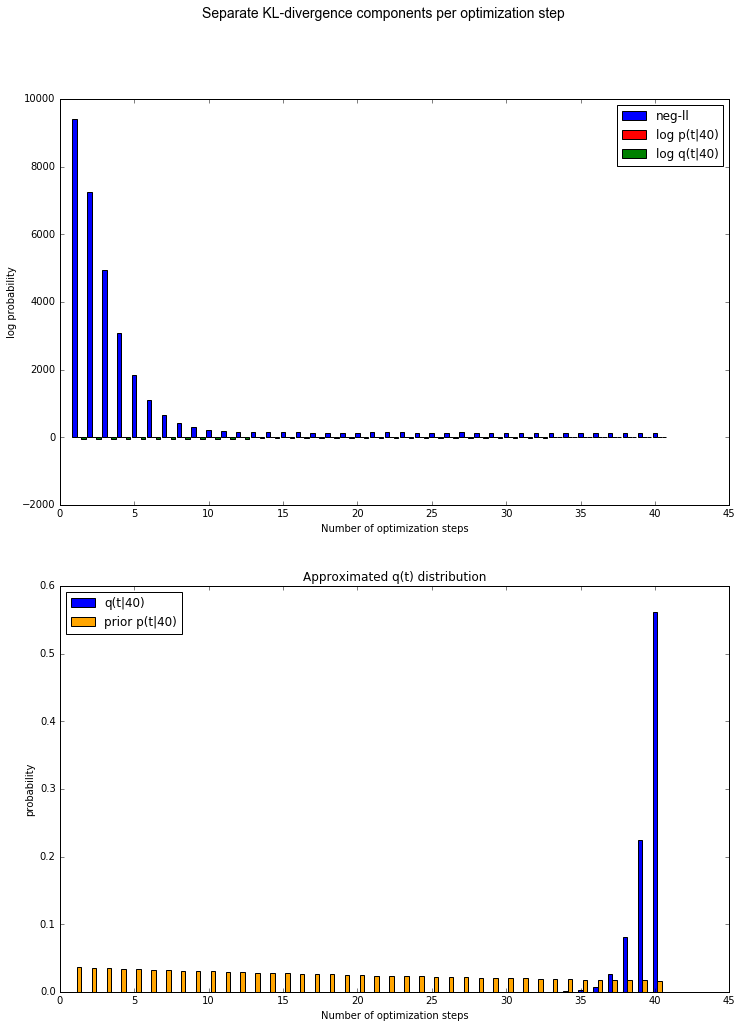

In [7]:
# 
plot_kl_div_parts(experiments[2], save=False, show=True, final_terms=False, log_qt=True, plot_prior=True,
                 fig_name="kl_parts_without_tanh")

INFO - Successfully saved fig logs/run_20170620_22_21_20_actV2_60ep_40ops_lr1e05_adam/qt_T_dist_val_actV2_60ep_40ops.png


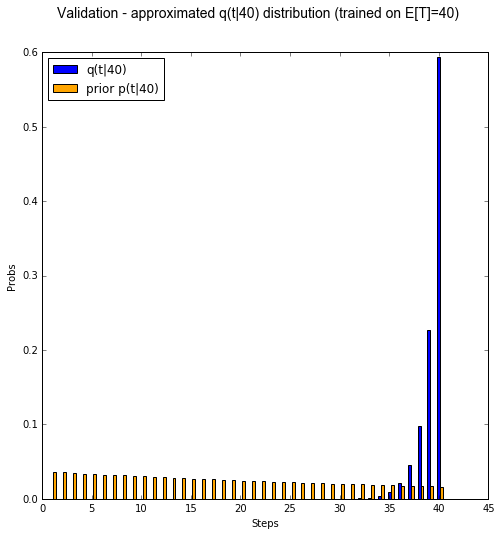

In [15]:
plot_qt_probs(experiments[2], data_set="val", save=True, show=True, 
              plot_prior=True, height=8, width=8, plot_idx=[40])

In [64]:
T = 18
qt = exper.val_stats["qt_hist"][30][T]
print(qt)

[  1.16585789e-07   2.66455341e-07   8.52595804e-07   3.67424379e-06
   1.81194540e-05   8.79444469e-05   3.64762319e-04   1.24599301e-03
   3.59000583e-03   8.96660400e-03   1.96767564e-02   3.81288907e-02
   6.54934732e-02   1.00561880e-01   1.39735819e-01   1.77958442e-01
   2.10353361e-01   2.33813039e-01]


In [122]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

[ 0.19309185  0.25614058  0.24058133  0.1808318   0.12935445]
[ 93.69465637  92.56275177  92.43516541  92.43141174  92.43121338
  92.42720032]
[ 0.11887669  0.23429963  0.27020574  0.21978717  0.15683077]
[ 104.62787628   92.92465973   92.43505859   92.42867279   92.42709351
   92.42713928]
[ 0.00903103  0.06211803  0.27155532  0.37283278  0.28446285]
[ 148.68551636  108.54633331   92.52172089   92.56498718   92.44163513
   92.43159485]
[ 0.02397113  0.11330524  0.29825712  0.32578054  0.23868597]
[ 130.93403625  101.6027832    92.51012421   92.4836731    92.43185425
   92.42990875]
[ 0.10979466  0.24725738  0.27810491  0.21425693  0.15058612]
[ 99.56502533  92.709198    92.44354248  92.42796326  92.42944336
  92.42945862]
[ 0.0390434   0.16535978  0.31182257  0.28158466  0.20218959]
[ 118.25817871   95.21542358   92.51622772   92.43270111   92.42834473
   92.43013   ]


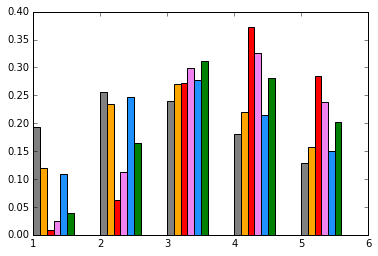

In [155]:
func_idx = [1, 15, 2499, 4999, 7499, 9999]
bar_width = 0.1
p_colors = ['grey', 'orange', 'red', 'violet', 'dodgerblue', 'green', 'darkviolet']
    
for i, idx in enumerate(func_idx):
    qt = exper.val_stats["qt_funcs"][5][idx]
    loss = exper.val_stats["loss_funcs"][idx,0:5+1]
    print(qt)
    print(loss)
    index = np.arange(1, len(qt)+1)
    plt.bar(index+ (i*bar_width), qt, bar_width, color=p_colors[i], label="f_{}".format(idx))

In [148]:
len(exper.val_stats["loss_funcs"][0])

10000

In [11]:
print(experiments[3].config.T)
print(experiments[3].config.continue_prob)

75
0.98
